# 1. Carga y exploración de la imagen #

### Justificación: antes de cualquier procesamiento, es necesario conocer el tipo, tamaño y canales de la imagen.

### Aquí identificamos si necesitamos trabajar en escala de grises o a color.

Dimensiones: (975, 1300, 3)


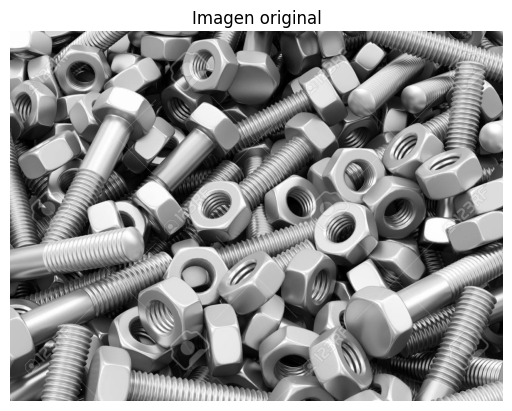

In [1]:
import cv2
import matplotlib.pyplot as plt

# Cargar imagen
img = cv2.imread("imagenes/img1.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convertimos de BGR a RGB para matplotlib

print("Dimensiones:", img.shape)
plt.imshow(img_rgb)
plt.title("Imagen original")
plt.axis("off")
plt.show()

# 2. Separación de canales y conversión a escala de grises

### Justificación: facilita el análisis reduciendo complejidad de 3 canales → 1 canal.

### El canal de mayor contraste con el fondo puede ser clave para la segmentación.

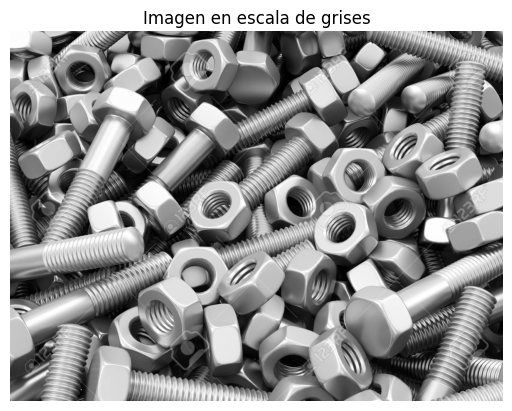

In [2]:
# Conversión a escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # se usa la imagen original en BGR para mejor precisión    
plt.imshow(gray, cmap="gray")
plt.title("Imagen en escala de grises")
plt.axis("off")
plt.show()


# 3. Umbralización (binaria y adaptativa)

### Umbral fijo: útil si la iluminación es uniforme.

### Umbral adaptativo: mejor si hay variaciones de luz en la imagen.

### Justificación: permite separar objetos (tornillos) del fondo.

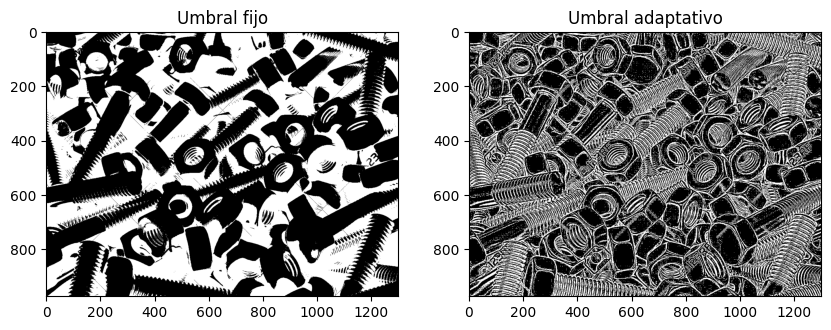

In [3]:
# Umbral fijo
_, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV) # si el umbral es 120, píxeles >120 se vuelven 0

# Umbral adaptativo
adaptive = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, # si el umbral es 120, píxeles >120 se vuelven 0
    cv2.THRESH_BINARY_INV, 11, 2
)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(thresh, cmap="gray"); ax[0].set_title("Umbral fijo")
ax[1].imshow(adaptive, cmap="gray"); ax[1].set_title("Umbral adaptativo")
plt.show()  # mostarmos las dos imágenes


# 4. Filtros espaciales

### Filtro Gaussiano: suaviza la imagen reduciendo ruido.

### Filtro Mediana: preserva bordes mientras elimina ruido impulsivo.

### Justificación: mejoran la calidad de la máscara para evitar falsos objetos.

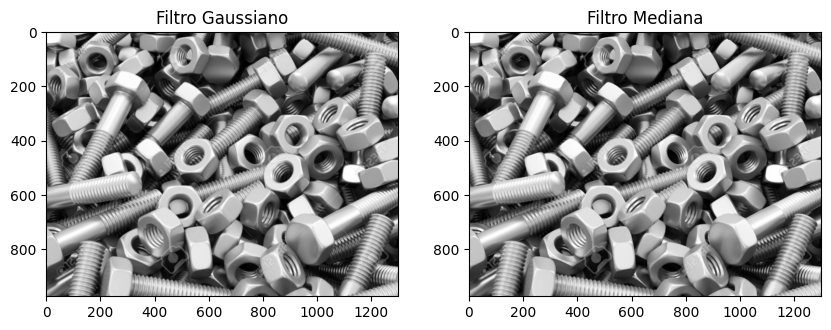

In [4]:
# Filtros espaciales
gaussian = cv2.GaussianBlur(gray, (5,5), 0)
median = cv2.medianBlur(gray, 5)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(gaussian, cmap="gray"); ax[0].set_title("Filtro Gaussiano")
ax[1].imshow(median, cmap="gray"); ax[1].set_title("Filtro Mediana")
plt.show() # mostramos ambos filtros


# 5. Operaciones lógicas

### AND: aplicar máscara sobre la imagen original.

### NOT: invertir si es necesario (fondo oscuro, objetos claros).

### Justificación: permiten refinar la segmentación combinando máscaras.

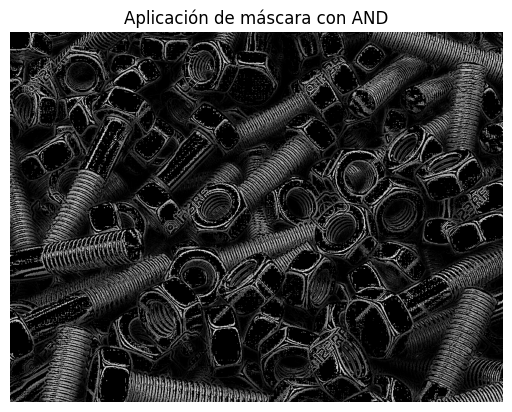

In [ ]:
mask = adaptive                                  # usamos la máscara del umbral adaptativo para la operación AND , ya que se ve mejor definicion en los tornillos
result = cv2.bitwise_and(gray, gray, mask=mask)  # aplicamos la máscara a la imagen en escala de grises para conservar la información de intensidad
plt.imshow(result, cmap="gray")
plt.title("Aplicación de máscara con AND")
plt.axis("off")
plt.show()


# 6. Operaciones morfológicas

### Apertura (erosión + dilatación): elimina ruido.

### Cierre (dilatación + erosión): rellena huecos en los tornillos.

### Gradiente morfológico: resalta bordes.

### Justificación: separan tornillos pegados y limpian imperfecciones.

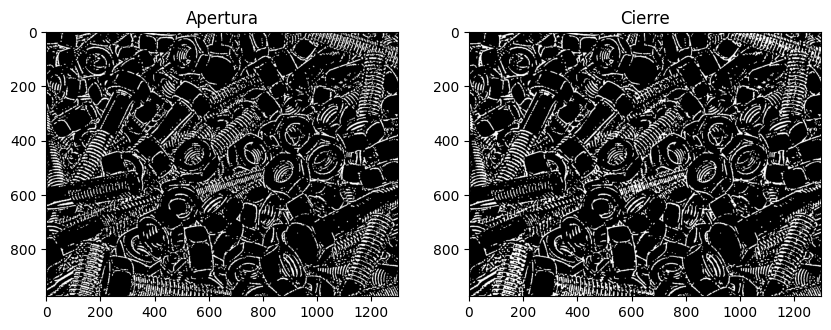

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))       # Kernel 3x3 para operaciones morfológicas

opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)         # Apertura
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)      # Cierre

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(opened, cmap="gray"); ax[0].set_title("Apertura")
ax[1].imshow(closed, cmap="gray"); ax[1].set_title("Cierre")
plt.show()                                                      # mostramos ambas operaciones morfológicas con los contornos más definidos


# 7. Segmentación y extracción de contornos

### Usamos componentes conectados o findContours.

### Justificación: detectar cada tornillo como objeto único.

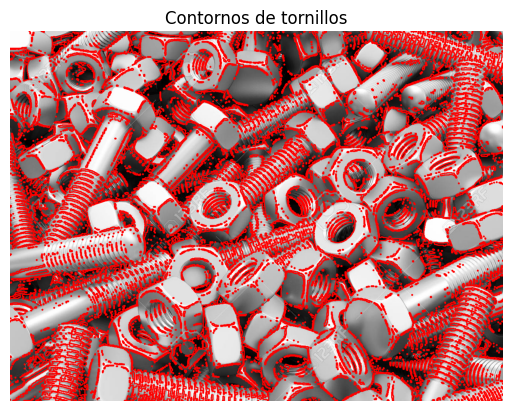

Número de tornillos detectados: 2733


In [7]:
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Encontrar contornos
img_contours = img_rgb.copy()                                                       # Copia de la imagen original para dibujar contornos  
cv2.drawContours(img_contours, contours, -1, (255,0,0), 2)                          # 2 es el grosor del contorno en pixeles (bordes finos)

plt.imshow(img_contours)
plt.title("Contornos de tornillos")
plt.axis("off")
plt.show()

print("Número de tornillos detectados:", len(contours))                             # se imprime el número de contornos detectados haciendo referencia a los tornillos 


# 8. Análisis de propiedades con regionprops

### Identificación de regiones conectadas.

### Cálculo de área, perímetro, centroides, orientación, bounding box.

### Justificación: permite no solo contar, sino obtener métricas relevantes.

In [8]:
import numpy as np
from skimage.measure import label, regionprops
import pandas as pd

# Etiquetado
labeled = label(closed)                     # etiquetado de la imagen binaria (llenado de regiones conectadas)
props = regionprops(labeled)                # propiedades de las regiones etiquetadas, usando la imagen binaria para calcular las propiedades

# Crear dataset con propiedades
data = []
for i, prop in enumerate(props, start=1):
    data.append({
        "ID": i,
        "Area": prop.area,
        "Perimetro": prop.perimeter,
        "Centroide_X": prop.centroid[1],  
        "Centroide_Y": prop.centroid[0],   
        "Orientacion": prop.orientation,
        "BBox": prop.bbox
    })

df = pd.DataFrame(data)                       # Crear DataFrame
print(df)

# Guardar en CSV
df.to_csv("tornillos_detectados.csv", index=False)


        ID  Area  Perimetro  Centroide_X  Centroide_Y  Orientacion  \
0        1  22.0  17.000000    52.409091     3.636364     0.359397   
1        2  26.0  19.621320    86.730769     1.076923     1.388738   
2        3   6.0   6.000000   196.000000     0.500000     1.570796   
3        4   6.0   6.000000   243.000000     0.500000     1.570796   
4        5   6.0   6.000000   280.000000     0.500000     1.570796   
...    ...   ...        ...          ...          ...          ...   
2734  2735   9.0   8.000000  1164.000000   973.000000    -0.785398   
2735  2736  11.0   9.414214  1173.363636   973.090909     1.307763   
2736  2737   6.0   6.000000   654.000000   973.500000     1.570796   
2737  2738   6.0   6.000000   806.000000   973.500000     1.570796   
2738  2739   6.0   6.000000  1075.000000   973.500000     1.570796   

                        BBox  
0             (0, 50, 8, 55)  
1             (0, 82, 4, 91)  
2           (0, 195, 2, 198)  
3           (0, 242, 2, 245)  
4   